##Домашнее задание № 2. Элементарные методы анализа временных рядов.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [2]:
from pylab import rcParams

import seaborn as sns

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-17 12:46:59--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K  1.02MB/s    in 0.7s    

2025-02-17 12:47:01 (1.02 MB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [4]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [5]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [6]:
series = monthly_boston_armed_robberies_j

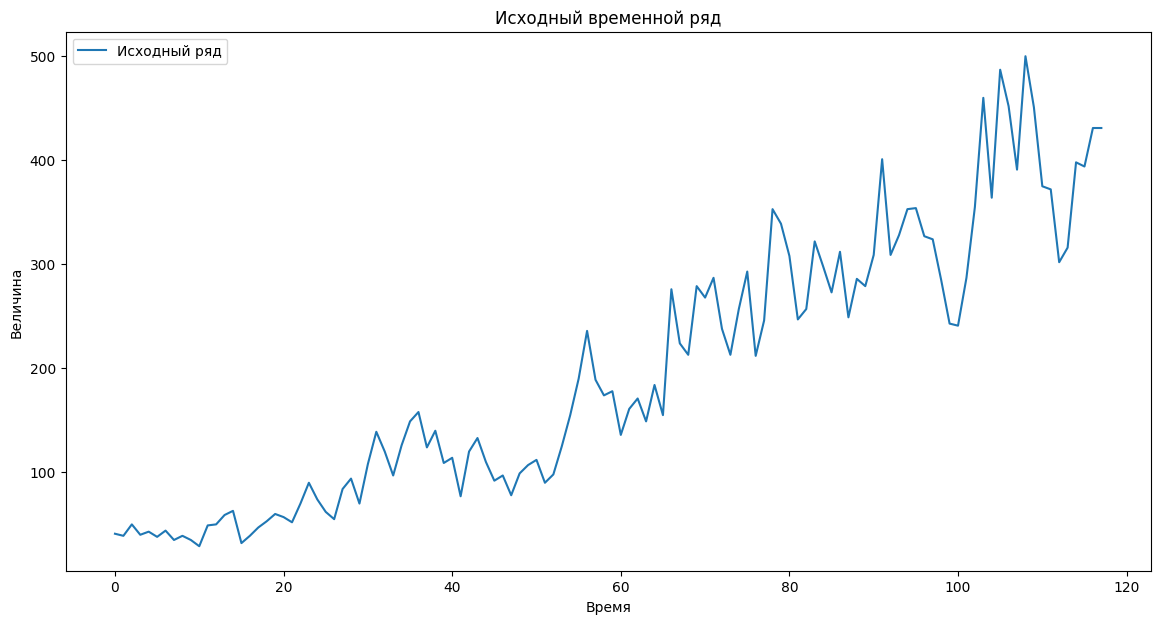

In [7]:
# еще раз на него посмотрим
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
#plt.plot(rolling_mean, label='Скользящее среднее', color='red')
#plt.plot(detrended, label='Detrended', color='green')
plt.title('Исходный временной ряд')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.grid(False)
plt.legend()
plt.show()

##Holt Winters

Рассчитаем Стандартизованную оценку (Z-Score) для каждого наблюдения, то есть меру удаленности от Среднего значения (Mean)

In [9]:
series['Standardized_assessment'] = (series['Count'] -
                                     series['Count'].mean()) / series['Count'].std(ddof=0)
series.head()

,Month,Count,Standardized_assessment
0,1966-01,41,-1.217947
1,1966-02,39,-1.233633
2,1966-03,50,-1.147359
3,1966-04,40,-1.225790
4,1966-05,43,-1.202261


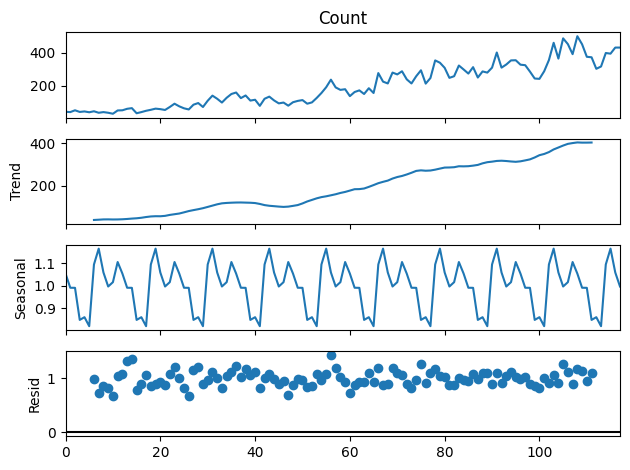

In [10]:
# разложим временной ряд на компоненты: тренд, сезонность и остатки
period = 12
decompose_result = seasonal_decompose(series['Count'],
                                      model='multiplicative',
                                      period=period)
decompose_result.plot()
plt.show()

Мне кажется, что прямо очень красиво такой сложный ряд разложился!

In [11]:
# разделим временной ряд на Train и Test
s_train = series['Count'][:int(0.8*len(series['Count']))]
s_test = series['Count'][int(0.8*len(series['Count'])):]

In [199]:
# создадим экземпляр класса Holt Winters
seasonal_periods = 12
model_triple = ExponentialSmoothing(s_train,
                                    seasonal_periods=seasonal_periods,
                                    trend='mul',
                                    seasonal='mul')
# обучим модель
model_triple_fit = model_triple.fit()

# получим предсказания на тестовом наборе
start = len(s_train)
end = len(series['Count'])-1
predictions = model_triple_fit.predict(start=start, end=end)

# получим предсказания на последующие периоды
next_periods = 24
predictions_next = model_triple_fit.predict(start=end, end=end+next_periods)

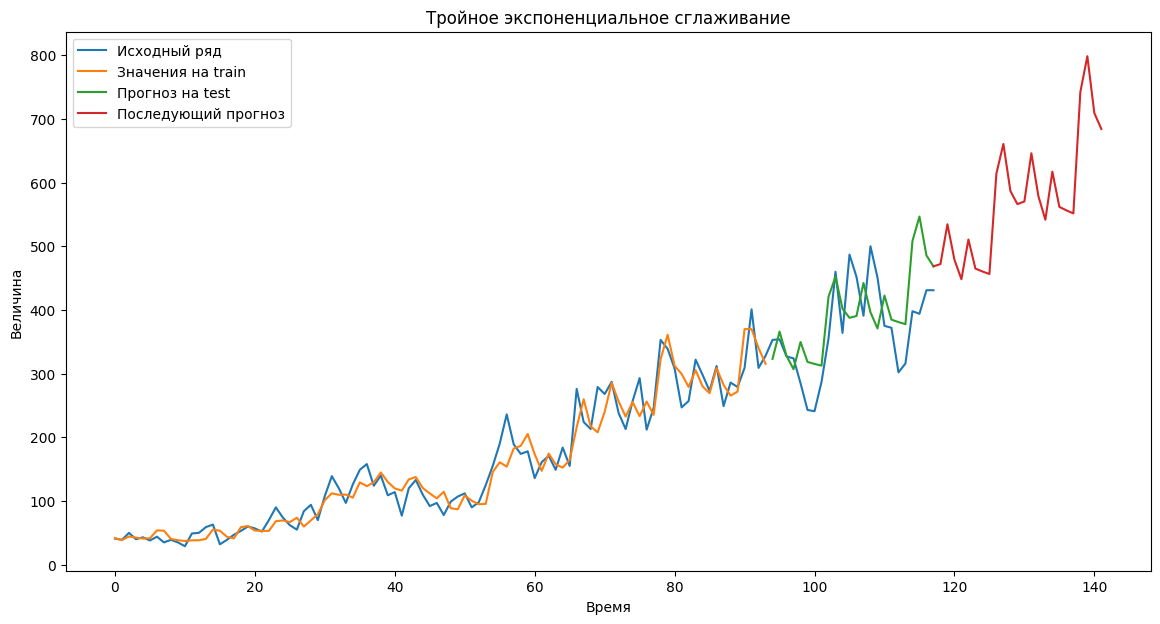

In [200]:
# нарисуем
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
plt.plot(model_triple_fit.fittedvalues, label='Значения на train')
plt.plot(predictions, label='Прогноз на test')
plt.plot(predictions_next, label='Последующий прогноз')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.title('Тройное экспоненциальное сглаживание')
plt.legend()
plt.show()

In [201]:
# оценим модель по MAE
mae = np.mean(np.abs(predictions-s_test))
print('Mean Absolute Error:', mae)

Mean Absolute Error: 56.78660877410161


##Поиск по сетке. Экспоненциальное сглаживание Холта Винтера

Попробуем оптимизировать параметры

In [238]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [239]:
# одношаговый прогноз экспоненциального сглаживания Холта Винтера
def exp_smoothing_forecast(train, test, config):
    # будем считаль, что период мы уже угадали верно
    seasonal_periods = 12
    t, d, s, r = config
	  # определим модель
    model = ExponentialSmoothing(train,
                                trend=t,
                                damped=d,
                                seasonal=s,
                                seasonal_periods=seasonal_periods)
	  # обучим модель
    model_fit = model.fit(optimized=True,
                          remove_bias=r
                         )
    # получим предсказания на тестовом наборе
    start = len(train)
    end = len(series['Count'])-1
    predictions = model_fit.predict(start=start, end=end)

    # оценим модель по MAE
    mae = np.mean(np.abs(predictions-test))

    return config, mae

In [242]:
# создадим набор конфигураций экспоненциального сглаживания
def exp_smoothing_configs():
    models = list()
	  # определим выборочный список настроек
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    r_params = [True, False]
	  # создадим экземпляры конфигурации
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for r in r_params:
                    cfg = [t, d, s, r]
                    models.append(cfg)
    return models

In [243]:
# поиск по сетке
def grid_search(cfg_list, train, test):
    scores = None
    result_cfg = []
    result_mae = []
    for cfg in cfg_list:
        try:
            config, mae = exp_smoothing_forecast(train, test, cfg)
            result_cfg.append(config)
            result_mae.append(mae)
        except:
            pass

    return result_cfg, result_mae

In [244]:
# разделим временной ряд на Train и Test
train = series['Count'][:int(0.8*len(series['Count']))]
test = series['Count'][int(0.8*len(series['Count'])):]

In [247]:
# конфигурации моделей
cfg_list = exp_smoothing_configs()
cfg_list[:5]

[['add', True, 'add', True],
 ['add', True, 'add', False],
 ['add', True, 'mul', True],
 ['add', True, 'mul', False],
 ['add', True, None, True]]

In [248]:
# выпоним поиск по сетке
result_cfg, result_mae = grid_search(cfg_list, train, test)
print('Конец!')

<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is depreca

Конец!


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,
<ipython-input-239-e4e96931e97d>:7: FutureWarning: the 'damped' keyword is deprecated, use

In [249]:
result_mae[:5]

[46.55306812013817,
 46.99547304067645,
 49.3530742288138,
 49.73804052421398,
 51.86778759579291]

In [250]:
# найдем нименьшее значение и его индекс
min(result_mae), result_mae.index(min(result_mae))

(44.28881217460816, 7)

In [251]:
# найдем оптимальную конфигурацию
result_cfg[result_mae.index(min(result_mae))]

['add', False, 'add', False]

In [252]:
# построим нашу оптимальную модель
seasonal_periods = 12
model = ExponentialSmoothing(train,
                             trend='add',
                             damped=False,
                             seasonal='add',
                             seasonal_periods=seasonal_periods)
# обучим модель
model_best = model.fit(optimized=True,
                       remove_bias=False
                      )
# получим предсказания на тестовом наборе
start = len(train)
end = len(series['Count'])-1
predictions = model_best.predict(start=start, end=end)

# получим предсказания на последующие периоды
next_periods = 24
predictions_next = model_best.predict(start=end, end=end+next_periods)

<ipython-input-252-54c9b3c311b4>:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train,


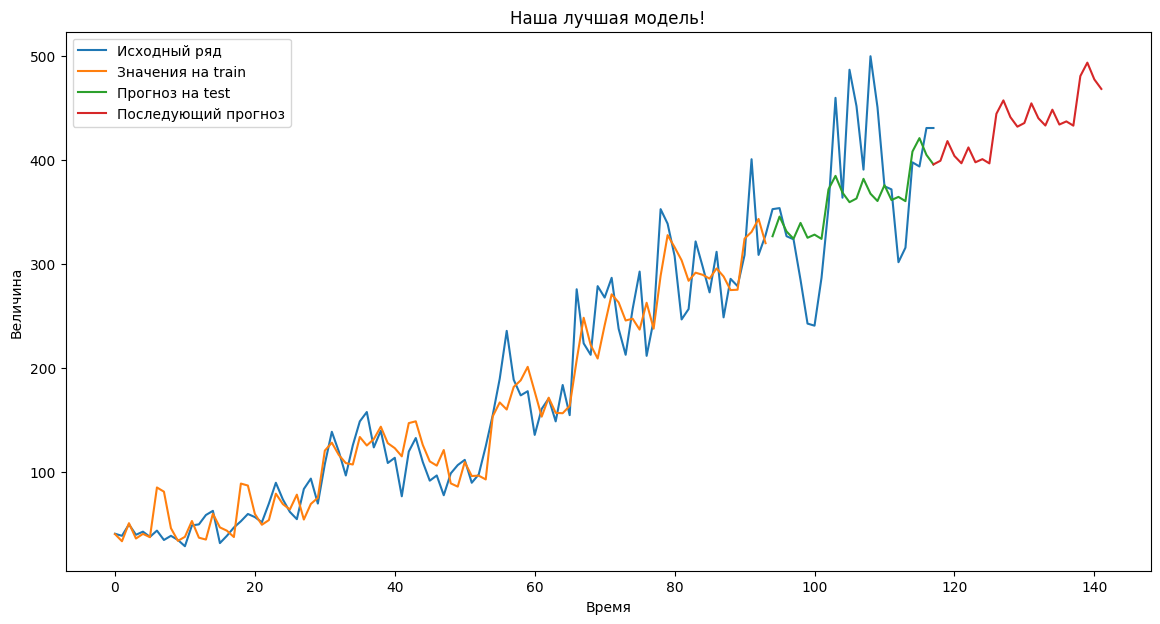

In [254]:
# нарисуем лучшую модель
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
plt.plot(model_best.fittedvalues, label='Значения на train')
plt.plot(predictions, label='Прогноз на test')
plt.plot(predictions_next, label='Последующий прогноз')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.title('Наша лучшая модель!')
plt.legend()
plt.show()

In [236]:
# оценим модель по MAE
mae = np.mean(np.abs(predictions-test))
print('Mean Absolute Error:', mae)

Mean Absolute Error: 44.28881217460816


Не факт, что стало лучше. Зато было интересно)